# Import thư viện

In [1]:
%load_ext autotime

time: 90.8 μs (started: 2025-01-23 16:59:03 +07:00)


In [3]:
import os
import cv2
import dill
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

time: 304 μs (started: 2025-01-23 16:59:12 +07:00)


# Tạo dataset

In [4]:
def load_data_from_directory(directory_path, lr_size=(240, 240), hr_size=(480, 480)):
    """
    Tải dữ liệu từ thư mục và chia thành các patch nhỏ cho cả ảnh LR và HR.

    Tham số:
    - directory_path (str): Đường dẫn tới thư mục chứa các ảnh LR và HR.
    - lr_size (tuple, mặc định (240, 240)): Kích thước mà ảnh LR sẽ được thay đổi kích thước về.
    - hr_size (tuple, mặc định (480, 480)): Kích thước mà ảnh HR sẽ được thay đổi kích thước về.
    - patch_size (int, mặc định 60): Kích thước của mỗi patch được chia từ ảnh LR. Các patch HR sẽ có kích thước gấp đôi (patch_size*2).

    Lý thuyết hoạt động:
    - Hàm này tìm các ảnh có tên kết thúc bằng '_LR.png' trong thư mục chỉ định.
    - Tạo tên ảnh HR tương ứng bằng cách thay thế phần '_LR.png' bằng '_HR.png'.
    - Nếu ảnh HR tồn tại, nó sẽ được tải cùng với ảnh LR.
    - Các ảnh LR và HR sẽ được thay đổi kích thước về các giá trị `lr_size` và `hr_size` tương ứng.
    - Ảnh sau đó sẽ được chuẩn hóa về phạm vi giá trị [0, 1] (định dạng float32).
    - Mỗi ảnh sẽ được chia thành các patch nhỏ có kích thước `patch_size` cho ảnh LR và `patch_size*2` cho ảnh HR.
    - Tất cả các patch của ảnh LR và HR sẽ được thu thập và trả về.

    Trả về:
    - lr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh LR.
      Mảng có kích thước (n, patch_size, patch_size), trong đó n là số lượng patch.
    - hr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh HR.
      Mảng có kích thước (n, patch_size*2, patch_size*2), trong đó n là số lượng patch.

    Ví dụ:
    >>> lr_images, hr_images = load_data_from_directory('path/to/directory', lr_size=(240, 240), hr_size=(480, 480))
    >>> print(lr_images.shape)
    (n, 60, 60)  # n là số lượng patch LR
    >>> print(hr_images.shape)
    (n, 120, 120)  # n là số lượng patch HR

    Lưu ý:
    - Hàm yêu cầu các ảnh LR phải có tên kết thúc bằng '_LR.png' và ảnh HR tương ứng phải có tên kết thúc bằng '_HR.png'.
    - Chỉ các ảnh có cả hai tệp LR và HR sẽ được xử lý.
    """
    
    lr_images = []
    hr_images = []

    # Lặp qua tất cả các file trong thư mục
    for filename in os.listdir(directory_path):
        if filename.endswith('_LR.png'):  # Tìm ảnh LR
            # Tạo tên ảnh HR tương ứng
            hr_filename = filename.replace('_LR.png', '_HR.png')

            # Xây dựng đường dẫn đầy đủ cho ảnh LR và HR
            lr_path = os.path.join(directory_path, filename)
            hr_path = os.path.join(directory_path, hr_filename)

            if os.path.exists(hr_path):  # Kiểm tra xem ảnh HR có tồn tại không
                # Đọc ảnh LR và HR
                
                lr_img = cv2.imread(lr_path)  # Đọc ảnh màu
                hr_img = cv2.imread(hr_path)  # Đọc ảnh màu
                
                lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB) # Chuyển ảnh sang màu RGB
                hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB) # Chuyển ảnh sang màu RGB
                
                # lr_img = cv2.imread(lr_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale (xám)
                # hr_img = cv2.imread(hr_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale (xám)

                if lr_img is not None and hr_img is not None:
                    # Resize ảnh về kích thước mong muốn
                    lr_img = cv2.resize(lr_img, lr_size)
                    hr_img = cv2.resize(hr_img, hr_size)

                    # Chuẩn hóa ảnh (0-1)
                    lr_img = lr_img.astype('float32') / 255.0
                    hr_img = hr_img.astype('float32') / 255.0

                    # Thêm các ảnh vào danh sách
                    lr_images.append(lr_img)
                    hr_images.append(hr_img)

    return lr_images, hr_images

time: 1.05 ms (started: 2025-01-23 16:59:13 +07:00)


In [5]:
directory_path = '/home/vodanhday/Downloads/BSD100/image_SRF_2'

lr_size = (240, 240)
hr_size = (480, 480)

lr_images, hr_images = load_data_from_directory(directory_path, lr_size, hr_size)

time: 752 ms (started: 2025-01-23 16:59:15 +07:00)


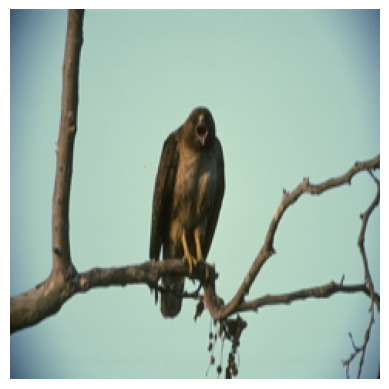

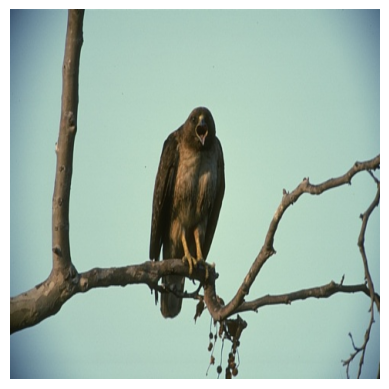

time: 204 ms (started: 2025-01-23 16:59:16 +07:00)


In [6]:
plt.imshow(lr_images[0])
plt.axis('off')
plt.show()

plt.imshow(hr_images[0])
plt.axis('off')
plt.show()

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

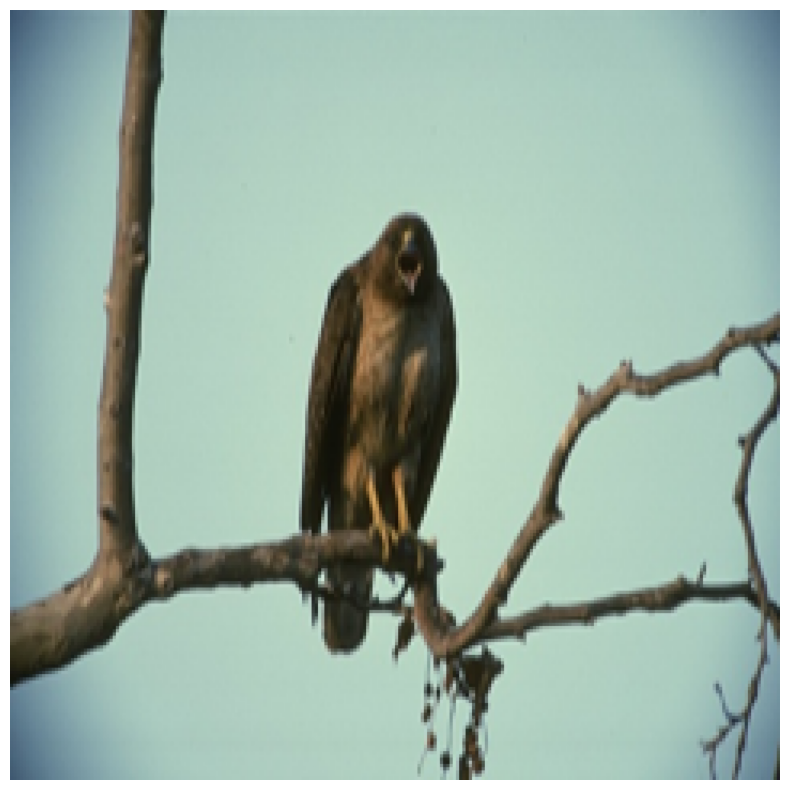

time: 207 ms (started: 2025-01-23 16:59:19 +07:00)


In [7]:
# def test(img, scale=2):
#     output = np.zeros((img.shape[0]*scale, img.shape[1]*scale, img.shape[2]))
    
#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             output[i*scale, j*scale, :] = img[i, j, :]
    
#     return output

def test(img, scale=2):
    img = img.repeat(scale, axis=0).repeat(scale, axis=1)
    return img

img = lr_images[0]
output_img = test(img, 2)

plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.axis('off')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(np.array(lr_images), np.array(hr_images), test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(len(X_train), len(X_val), len(X_test))

72 8 20
time: 253 ms (started: 2025-01-23 16:59:22 +07:00)


# Thực hiện xây dựng model

In [15]:
class Layer:
    def __init__(self):
        self.shape = {'input': None, 'output': None}
        self.weights = None
        self.bias = None
        self.activation = None
        self.scale = None
        self.feature_map = {'Z': None, 'A': None, 'A_prev': None}
        self.gradient = {'dW': None, 'db': None, 'dA': None, 'dZ': None, 'dgamma': None, 'dbeta': None}
        self.conv = {'stride': None, 'padding': None, 'kernel_size': None, 'num_filters': None}
        self.batch_norm = {'gamma': None, 'beta': None, 'mean': None, 'var': None, 'epsilon': None, 'momentum': None}
        self.names = []

    def Input(self, shape):
        self.shape['input'] = self.shape['output'] = shape
        self.names.append('Input')
        return self

    def Upscale(self, scale=2):
        h, w, c = self.shape['input']
        self.shape['output'] = [h * scale, w * scale, c]
        self.scale = scale
        self.names.append('Upscale')
        return self

    def Conv2D(self, num_filters, kernel_size, stride=1, padding="same", activation=None):
        self.weights = np.random.randn(kernel_size, kernel_size, self.shape['input'][2], num_filters) * 0.01
        self.bias = np.zeros((1, 1, 1, num_filters))

        padding_value = {'same': (kernel_size - stride) // 2, 'valid': 0}.get(padding, padding)
        if isinstance(padding_value, int):
            self.conv.update({'stride': stride, 'padding': padding_value,
                              'kernel_size': kernel_size, 'num_filters': num_filters})
        else:
            raise ValueError(f"Unsupported padding '{padding}'.")

        h, w, _ = self.shape['input']
        self.shape['output'] = [
            (h - kernel_size + 2 * padding_value) // stride + 1,
            (w - kernel_size + 2 * padding_value) // stride + 1,
            num_filters
        ]
        self.activation = activation
        self.names.append('Conv2D')
        if activation:
            self.names.append('Activation')
        return self

    def BatchNormalization(self, epsilon=1e-5, momentum=0.9):
        self.batch_norm['gamma'] = np.ones((1, 1, 1, self.shape['output'][2]))
        self.batch_norm['beta'] = np.zeros((1, 1, 1, self.shape['output'][2]))
        self.batch_norm['epsilon'] = epsilon
        self.batch_norm['momentum'] = momentum
        self.names.append('BatchNormalization')
        return self

    def activate(self, Z):
        if self.activation == "relu":
            return np.maximum(0, Z)
        return Z

    def activate_derivative(self, Z):
        if self.activation == "relu":
            return (Z > 0).astype(float)
        return np.ones_like(Z)

    def forward(self, A_prev):
        self.feature_map['A_prev'] = A_prev
        A = A_prev
        for name in self.names:
            if name == 'Upscale':
                scale = self.scale
                A = A.repeat(scale, axis=1).repeat(scale, axis=2)
            elif name == 'Conv2D':
                A = self._forward_conv2d(A)
            elif name == 'BatchNormalization':
                A = self._forward_batchnorm(A)
            elif name == 'Activation':
                A = self.activate(self.feature_map['Z'])
        self.feature_map['A'] = A
        return A

    def _forward_conv2d(self, A_prev):
        A_prev_pad = self.add_padding(A_prev)
        A_col = self.im2col(A_prev_pad)
        W_col = self.weights.reshape(-1, self.conv['num_filters'])

        Z = np.dot(A_col, W_col) + self.bias.reshape(-1)

        n, h_out, w_out, c_out = A_prev.shape[0], *self.shape['output']
        Z = Z.reshape(n, h_out, w_out, c_out)

        self.feature_map['Z'] = Z
        return Z

    def _forward_batchnorm(self, A_prev):
        gamma = self.batch_norm['gamma']
        beta = self.batch_norm['beta']
        epsilon = self.batch_norm['epsilon']

        mean = np.mean(A_prev, axis=(0, 1, 2), keepdims=True)
        var = np.var(A_prev, axis=(0, 1, 2), keepdims=True)

        self.batch_norm['mean'] = mean
        self.batch_norm['var'] = var

        A_norm = (A_prev - mean) / np.sqrt(var + epsilon)
        A_out = gamma * A_norm + beta

        self.feature_map['A_norm'] = A_norm
        self.feature_map['A_prev'] = A_prev

        return A_out

    def backward(self, dA):
        for name in reversed(self.names):
            if name == 'Upscale':
                scale = self.scale
                dA = dA[:, ::scale, ::scale, :]
            elif name == 'Activation':
                dA *= self.activate_derivative(self.feature_map['Z'])
            elif name == 'BatchNormalization':
                dA = self._backward_batchnorm(dA)
            elif name == 'Conv2D':
                dA = self._backward_conv2d(dA)
        return dA

    def _backward_conv2d(self, dA):
        A_prev = self.feature_map['A_prev']
        A_prev_pad = self.add_padding(A_prev)
        A_prev_col = self.im2col(A_prev_pad)
        A_prev_col = A_prev_col.reshape(-1, A_prev_col.shape[-1])

        dZ_col = dA.reshape(-1, self.conv['num_filters'])

        self.gradient['dW'] = (A_prev_col.T @ dZ_col).reshape(self.weights.shape)
        self.gradient['db'] = dZ_col.sum(axis=0).reshape(self.bias.shape)

        W_col = self.weights.reshape(-1, self.conv['num_filters'])
        dA_col = dZ_col @ W_col.T
        dA_prev = self.col2im(dA_col)

        return dA_prev

    def _backward_batchnorm(self, dA):
        A_prev = self.feature_map['A_prev']
        A_norm = self.feature_map['A_norm']
        gamma = self.batch_norm['gamma']
        beta = self.batch_norm['beta']
        epsilon = self.batch_norm['epsilon']
        mean = self.batch_norm['mean']
        var = self.batch_norm['var']

        N, H, W, C = A_prev.shape

        dgamma = np.sum(dA * A_norm, axis=(0, 1, 2), keepdims=True)
        dbeta = np.sum(dA, axis=(0, 1, 2), keepdims=True)

        dA_norm = dA * gamma

        dvar = np.sum(dA_norm * (A_prev - mean) * -0.5 * (var + epsilon) ** -1.5, axis=(0, 1, 2), keepdims=True)

        dmean = np.sum(dA_norm * -1 / np.sqrt(var + epsilon), axis=(0, 1, 2), keepdims=True) + \
                dvar * np.sum(-2 * (A_prev - mean), axis=(0, 1, 2), keepdims=True) / (N * H * W)

        dA_prev = dA_norm / np.sqrt(var + epsilon) + \
                dvar * 2 * (A_prev - mean) / (N * H * W) + \
                dmean / (N * H * W)

        self.gradient['dgamma'] = dgamma
        self.gradient['dbeta'] = dbeta

        return dA_prev

    def im2col(self, A):
        k, s = self.conv['kernel_size'], self.conv['stride']
        n, h, w, c = A.shape

        h_out = (h - k) // s + 1
        w_out = (w - k) // s + 1

        col = []
        for i in range(0, h_out):
            for j in range(0, w_out):
                col.append(A[:, i*s:i*s+k, j*s:j*s+k, :].reshape(n, -1))
        col = np.stack(col, axis=1)
        return col

    def col2im(self, cols):
        k, s, p = self.conv['kernel_size'], self.conv['stride'], self.conv['padding']
        n, h, w, c = self.feature_map['A_prev'].shape

        h_out = (h + 2 * p - k) // s + 1
        w_out = (w + 2 * p - k) // s + 1

        A_prev_pad = np.zeros((n, h + 2 * p, w + 2 * p, c))
        cols = cols.reshape(n, h_out, w_out, k, k, c)

        for i in range(h_out):
            for j in range(w_out):
                h_start = i * s
                w_start = j * s
                A_prev_pad[:, h_start:h_start + k, w_start:w_start + k, :] += cols[:, i, j, :, :, :]

        if p > 0:
            A_prev = A_prev_pad[:, p:-p, p:-p, :]
        else:
            A_prev = A_prev_pad

        return A_prev

    def add_padding(self, A):
        p = self.conv['padding']
        return np.pad(A, ((0, 0), (p, p), (p, p), (0, 0)), mode='constant')

    def update_params(self, lr):
        if self.gradient['dW'] is None or self.gradient['db'] is None:
            return
        else:
            for name in self.names:
                if name == 'Conv2D':
                    self.weights -= lr * self.gradient['dW']
                    self.bias -= lr * self.gradient['db']
                elif name == 'BatchNormalization':
                    self.batch_norm['gamma'] -= lr * self.gradient['dgamma']
                    self.batch_norm['beta'] -= lr * self.gradient['dbeta']

    def get_params(self):
        return {k: getattr(self, k) for k in ['weights', 'bias', 'activation', 'shape', 'conv', 'gradient', 'feature_map', 'names']}

    def set_params(self, params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

time: 8.33 ms (started: 2025-01-23 17:53:46 +07:00)


In [11]:
class SRCNN:
    def __init__(self):
        self.layers = []
        self.optimizer = {'loss_fn': None, 'metrics': []}
        self.current_shape = None
        self.best_weights = None
        self.learning_rate = None
        self.continue_training = False
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_metric': {},
            'val_metric': {}
        }

    def add(self, layer):
        """Thêm một lớp vào mô hình."""
        self.current_shape = layer.shape['output']
        self.layers.append(layer)

    def forward(self, X):
        """Lan truyền xuôi."""
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, output, Y, learning_rate):
        """Lan truyền ngược và cập nhật tham số."""
        dA = self._calculate_gradient(output, Y, self.optimizer['loss_fn'].__name__)
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
            layer.update_params(learning_rate)

    @staticmethod
    def _mse_loss_gradient(output, Y):
        return 2 * (output - Y)

    def _calculate_gradient(self, output, Y, grad_fn):
        if grad_fn == 'mse_loss':
            return self._mse_loss_gradient(output, Y)
        else:
            raise ValueError(f"Unsupported loss function '{grad_fn}'.")

    def train(self, X_train, Y_train, epochs, learning_rate, batch_size=32, X_val=None, Y_val=None,
              early_stopping_rounds=7, lr_patience=3, lr_factor=0.2):
        """Huấn luyện mô hình."""
        current_lr = self.learning_rate if self.continue_training else learning_rate
        best_val_loss, no_improvement_rounds = float('inf'), 0
        if not self.continue_training:
            self._reset_history()

        for epoch in range(epochs):
            progress_bar = tqdm(range(X_train.shape[0] // batch_size), desc=f"Epoch {epoch + 1}/{epochs}", unit="step")
            train_loss, train_metrics = self._train_epoch(X_train, Y_train, batch_size, progress_bar, current_lr)

            if X_val is not None and Y_val is not None:
                val_loss, val_metrics = self._validate_epoch(X_val, Y_val)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_rounds = 0
                    self.best_weights = [layer.get_params() for layer in self.layers]
                else:
                    no_improvement_rounds += 1

                if early_stopping_rounds and no_improvement_rounds >= early_stopping_rounds:
                    print(f"Early stopping at epoch {epoch + 1}")
                    self.set_weights(self.best_weights)
                    break

                if no_improvement_rounds >= lr_patience:
                    current_lr *= lr_factor
                    self.learning_rate = current_lr
                    print(f"Reducing learning rate to {current_lr}")

            self._log_epoch(epoch, train_loss, train_metrics, val_loss, val_metrics)

    def _reset_history(self):
        if not self.continue_training:
            self.history = {
                'train_loss': [],
                'val_loss': [],
                'train_metric': {metric.__name__: [] for metric in self.optimizer['metrics']},
                'val_metric': {metric.__name__: [] for metric in self.optimizer['metrics']}
            }

    def _train_epoch(self, X_train, Y_train, batch_size, progress_bar, learning_rate):
        """Huấn luyện 1 epoch."""
        epoch_loss, epoch_metrics = 0, {metric.__name__: 0 for metric in self.optimizer['metrics']}
        for step in progress_bar:
            start, end = step * batch_size, (step + 1) * batch_size
            X_batch, Y_batch = X_train[start:end], Y_train[start:end]
            output = self.forward(X_batch)

            loss = self.optimizer['loss_fn'](output, Y_batch)
            epoch_loss += loss
            for metric in self.optimizer['metrics']:
                epoch_metrics[metric.__name__] += metric(output, Y_batch)

            self.backward(output, Y_batch, learning_rate)
            progress_bar.set_postfix(loss=epoch_loss / (step + 1),
                                     **{name: epoch_metrics[name] / (step + 1) for name in epoch_metrics})
        return epoch_loss / len(progress_bar), {name: epoch_metrics[name] / len(progress_bar) for name in epoch_metrics}

    def _validate_epoch(self, X_val, Y_val):
        """Xác thực 1 epoch."""
        val_output = self.forward(X_val)
        val_loss = self.optimizer['loss_fn'](val_output, Y_val)
        val_metrics = {metric.__name__: metric(val_output, Y_val) for metric in self.optimizer['metrics']}
        return val_loss, val_metrics

    def _log_epoch(self, epoch, train_loss, train_metrics, val_loss=None, val_metrics=None):
        """Ghi lại lịch sử huấn luyện."""
        self.history['train_loss'].append(train_loss)
        for name, value in train_metrics.items():
            self.history['train_metric'][name].append(value)

        if val_loss is not None:
            self.history['val_loss'].append(val_loss)
            for name, value in val_metrics.items():
                self.history['val_metric'][name].append(value)
            print(f"Epoch {epoch + 1} - loss: {train_loss:.4f} - " +
                      " - ".join([f"{name}: {value:.4f}" for name, value in train_metrics.items()]) +
                      f" - val_loss: {val_loss:.4f} - " + " - ".join([f"{name}: {value:.4f}" for name, value in val_metrics.items()]))
        else:
            print(f"Epoch {epoch + 1} - loss: {train_loss:.4f} - " +
                      " - ".join([f"{name}: {value:.4f}" for name, value in train_metrics.items()]))

    def compile(self, loss_fn, metrics=None):
        """Cấu hình hàm mất mát và các chỉ số."""
        self.optimizer['loss_fn'] = loss_fn
        self.optimizer['metrics'] = metrics or []

    def predict(self, X):
        """Dự đoán."""
        return self.forward(X)

    def evaluate(self, X, Y):
        """Đánh giá mô hình."""
        output = self.predict(X)
        loss = self.optimizer['loss_fn'](output, Y)
        metrics = {metric.__name__: metric(output, Y) for metric in self.optimizer['metrics']}
        return loss, metrics

    def summary(self):
        total_params = 0
        print("Model Summary:")
        print("="*50)

        for i, layer in enumerate(self.layers):
            layer_name = layer.__class__.__name__
            for name in layer.names:
                layer_name += f" -> {name}"
            print(f"Layer {i+1}: {layer_name}")

            input_shape = layer.shape['input'] if layer.shape['input'] else 'None'
            output_shape = layer.shape['output'] if layer.shape['output'] else 'None'
            kernel_shape = layer.weights.shape if layer.weights is not None else 'None'
            print(f"  Input Shape: {input_shape}")
            print(f"  Kernel Shape: {kernel_shape}")
            print(f"  Output Shape: {output_shape}")

            num_params = 0
            if hasattr(layer, 'weights') and layer.weights is not None:
                num_params += np.prod(layer.weights.shape)
            if hasattr(layer, 'bias') and layer.bias is not None:
                num_params += np.prod(layer.bias.shape)
            if hasattr(layer, 'batch_norm'):
                if 'gamma' in layer.batch_norm and layer.batch_norm['gamma'] is not None:
                    num_params += np.prod(layer.batch_norm['gamma'].shape)
                if 'beta' in layer.batch_norm and layer.batch_norm['beta'] is not None:
                    num_params += np.prod(layer.batch_norm['beta'].shape)

            total_params += num_params
            print(f"  Number of Parameters: {num_params}")
            print("-"*50)

        print(f"Total Parameters: {total_params}")
        print("="*50)

time: 4.12 ms (started: 2025-01-23 16:59:31 +07:00)


In [12]:
def mse_loss(predicted, target):
    return ((predicted - target) ** 2).mean()

def psnr_metric(predicted, target, max_val=1.0):
    mse = mse_loss(predicted, target)
    if(mse == 0):
        return 100
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

def ssim_metric(predicted, target):
    predicted = tf.convert_to_tensor(predicted, dtype=tf.float32)
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    ssim = tf.image.ssim(predicted, target, max_val=1.0)
    return ssim.numpy().mean()

time: 515 μs (started: 2025-01-23 16:59:34 +07:00)


In [16]:
model = SRCNN()

model.add(Layer().Input((240, 240, 3)).Upscale(scale=2))

num_filters = [12, 6, 6, 3]
kernel_sizes = [7, 5, 3, 3]

for kernel_size, num_filter in zip(kernel_sizes, num_filters):
    model.add(Layer().Input(model.current_shape).Conv2D(num_filter, kernel_size, padding="same", activation="relu"))
    model.add(Layer().Input(model.current_shape).BatchNormalization())

model.compile(loss_fn=mse_loss, metrics=[psnr_metric, ssim_metric])
model.summary()

Model Summary:
Layer 1: Layer -> Input -> Upscale
  Input Shape: (240, 240, 3)
  Kernel Shape: None
  Output Shape: [480, 480, 3]
  Number of Parameters: 0
--------------------------------------------------
Layer 2: Layer -> Input -> Conv2D -> Activation
  Input Shape: [480, 480, 3]
  Kernel Shape: (7, 7, 3, 12)
  Output Shape: [480, 480, 12]
  Number of Parameters: 1776
--------------------------------------------------
Layer 3: Layer -> Input -> BatchNormalization
  Input Shape: [480, 480, 12]
  Kernel Shape: None
  Output Shape: [480, 480, 12]
  Number of Parameters: 24
--------------------------------------------------
Layer 4: Layer -> Input -> Conv2D -> Activation
  Input Shape: [480, 480, 12]
  Kernel Shape: (5, 5, 12, 6)
  Output Shape: [480, 480, 6]
  Number of Parameters: 1806
--------------------------------------------------
Layer 5: Layer -> Input -> BatchNormalization
  Input Shape: [480, 480, 6]
  Kernel Shape: None
  Output Shape: [480, 480, 6]
  Number of Parameters: 1

In [19]:
model.train(X_train, y_train, epochs=1, learning_rate=0.5, batch_size=4, X_val=X_val, Y_val=y_val, early_stopping_rounds=10, lr_patience=5, lr_factor=0.25)

Epoch 1/1:   0%|          | 0/18 [00:00<?, ?step/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

time: 308 ms (started: 2025-01-23 17:57:43 +07:00)
